# Deep Learning Project : Cats and Dogs Classification

**The Dogs vs. Cats dataset is a standard computer vision dataset 
that involves classifying photos as either containing a dog or cat.**

1. The training contains 25,000 images of dogs and cats. 
2. Train your algorithm on these files and predict the labels (1 = dog, 0 = cat).

# 1. Import Python modules

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import PIL
import pathlib
import random
import seaborn as sns

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Dropout, Flatten,Activation, BatchNormalization,MaxPooling2D
from tensorflow.keras import datasets, layers, models
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, f1_score, recall_score

# 2. Load dataset

In [36]:
data_dir = pathlib.Path("PetImages/")

# Cats and dogs
cats = list(data_dir.glob('Cat/*'))
dogs = list(data_dir.glob('Dog/*'))


## 2.1 Data visualization

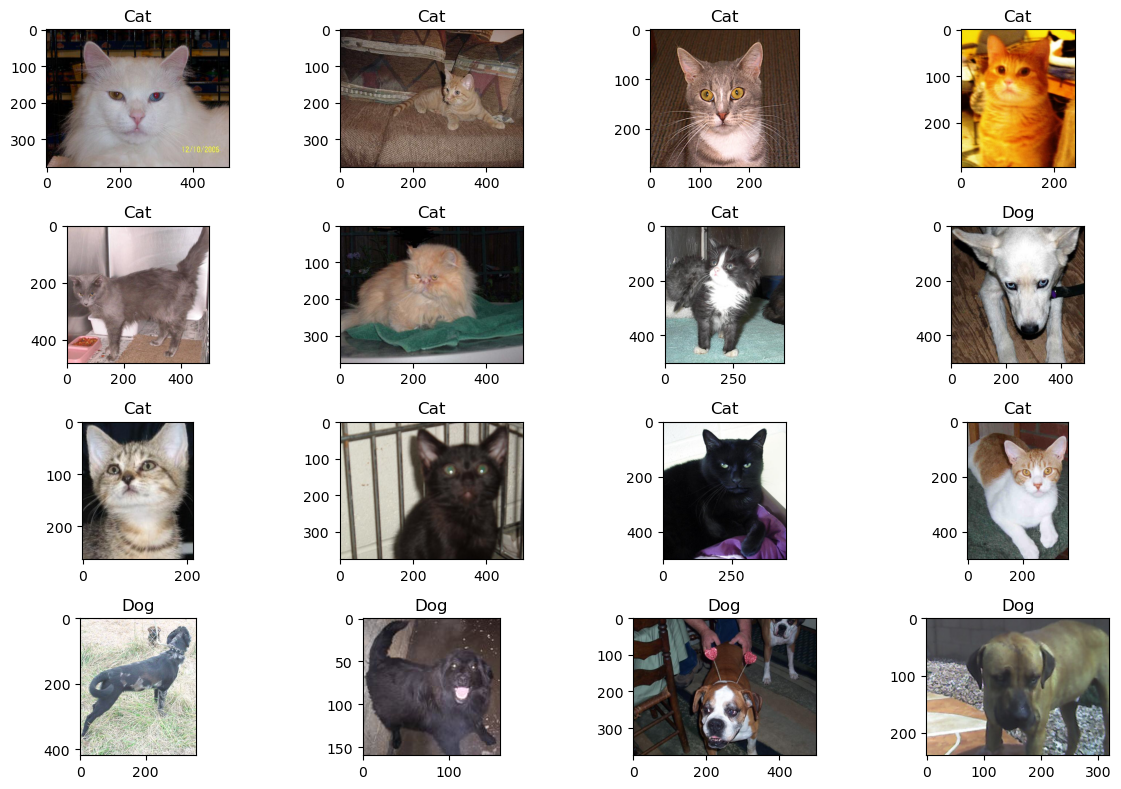

In [80]:
preview_files = random.sample(cats+dogs, 16)

plt.figure(figsize=(12,8))

for i, image_file in enumerate(preview_files, 1):
    plt.subplot(4, 4, i)
    
    img = PIL.Image.open(str(image_file))
    plt.imshow(img)
    
    label = str(image_file).split('\\')[-2]
    plt.title(label)

plt.tight_layout()
plt.show()

In [71]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

25000



# 3. Read Pets images from disk into numpy array using opencv

In [134]:
pet_images_dict = {
    'cats': list(data_dir.glob('Cat/*')),
    'dogs': list(data_dir.glob('Dog/*')),
}

pet_labels_dict = {
    'cats': 0,
    'dogs': 1,
}

#pet_images_dict['cats'][:5]
#pet_images_dict['dogs'][:5]

#pet_labels_dict['cats']
#pet_labels_dict['dogs']

In [135]:
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
X, Y = [], []

for pet_name, images in pet_images_dict.items():
    print(pet_name)
    for image in images:
        img = cv2.imread(str(image))
        if isinstance(img,type(None)): 
            #print('image not found')
            continue
        elif ((img.shape[0] >= IMAGE_HEIGHT) and  (img.shape[1] >=IMAGE_WIDTH)):
            resized_img = cv2.resize(img,(IMAGE_WIDTH,IMAGE_HEIGHT))
            X.append(resized_img)
            Y.append(pet_labels_dict[pet_name])
        else:
            #print("Invalid Image")
            continue

cats
dogs


In [136]:
X = np.array(X)
Y = np.array(Y)

# 4. Train Test split

In [137]:
delta = 1E-6
epsilon = 0.08
n_c = int(np.ceil((7.47) / epsilon * np.log(1 / delta)))

X_learn, X_test, Y_learn,Y_test = train_test_split(X,Y, test_size = 0.30, random_state = 5)

X_train, X_cal, Y_train, Y_cal = train_test_split(X_learn,Y_learn, test_size = n_c, random_state = 5)

print('Training set size: ', len(Y_train))
print('Test set size: ', len(Y_test))
print('Calibration set size: ', len(Y_cal))


Training set size:  15814
Test set size:  7332
Calibration set size:  1291



# 5. Build convolutional neural network and train it

## 5.1 CNN architecture

In [139]:
IMAGE_CHANNELS=3
model = Sequential([

Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)),
BatchNormalization(),
MaxPooling2D(pool_size=(2, 2)),
Dropout(0.25),

Conv2D(64, (3, 3), activation='relu'),
BatchNormalization(),
MaxPooling2D(pool_size=(2, 2)),
Dropout(0.25),

Conv2D(128, (3, 3), activation='relu'),
BatchNormalization(),
MaxPooling2D(pool_size=(2, 2)),
Dropout(0.25),

Flatten(),
Dense(512, activation='relu'),
BatchNormalization(),
Dropout(0.5),
Dense(1, activation='sigmoid'), # 2 because we have cat and dog classes, sigmoid
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_20 (Ba  (None, 126, 126, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_20 (Dropout)        (None, 63, 63, 32)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_21 (Ba  (None, 61, 61, 64)       

## 5.2 Traininig

In [144]:
history=model.fit(X_train, Y_train, epochs=1)

495/495 [==============================] - 298s 599ms/step - loss: 0.6897 - accuracy: 0.6645


## 5.3 Save the model

In [145]:
# save the model to file
import os
from os.path import exists
if not exists("models/"):
    os.mkdir("models/")

model.save("models/CNN_cats_dogs_20240115.keras")
# to load a trained model from file 
# model = keras.models.load_model('path/to/location.keras')

## 5.4 Load a model

In [140]:
# to load a trained model from file 
model = keras.models.load_model('models/CNN_cats_dogs_20240115.keras')

# 6 Model evaluation

In [146]:
# compute probabilities on test set
p_ts = model.predict(X_test)-0.5

230/230 [==============================] - 25s 109ms/step


In [147]:
# decision function
y_pred_ts = []
for p in p_ts:
    if p<0:
        y_pred_ts.append(0)
    else:
        y_pred_ts.append(1)

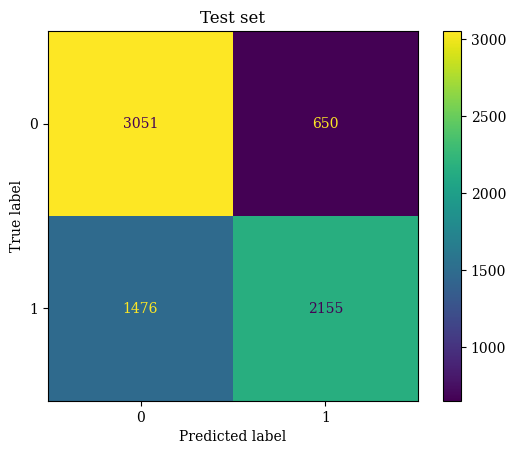

ACC = 0.710038188761593, F1 = 0.6696706028589186, PPV = 0.768270944741533, NPV = 0.6739562624254473, TPR = 0.5935004131093363, TNR = 0.8243717914077276

FPR = 0.17562820859227235, FNR = 0.40649958689066373
TP = 2155, FP = 650, TN = 3051, FN = 1476


In [148]:
cm_svm = confusion_matrix(Y_test, y_pred_ts)
cmSVM = ConfusionMatrixDisplay(confusion_matrix=cm_svm)
cmSVM.plot()
cmSVM.ax_.set_title("{}".format("Test set"))
plt.show()

TN, FP, FN, TP = confusion_matrix(Y_test, y_pred_ts).ravel()


accuracy = (TP+TN)/(TP+TN+FP+FN)
f1 = (2*TP)/(2*TP+FP+FN)
PPV = TP/(TP+FP)
NPV = TN/(TN+FN)
TPR = TP/(TP+FN)
TNR = TN/(TN+FP)
FPR = FP/(FP+TN)
FNR = FN/(FN+TP)

print("ACC = {}, F1 = {}, PPV = {}, NPV = {}, TPR = {}, TNR = {}\n".format(accuracy,f1,PPV,NPV,TPR,TNR))

print(f"FPR = {FPR}, FNR = {FNR}")

print("TP = {}, FP = {}, TN = {}, FN = {}".format(TP,FP,TN,FN))

# 7 Probabilistic Scaling

## 7.1 Calibration data exploration

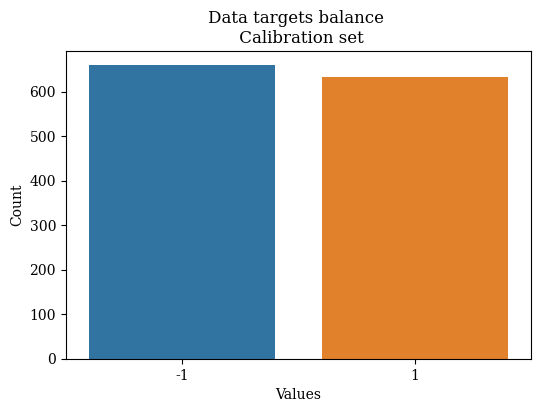

In [149]:
Y_cal_series = pd.Series(Y_cal)

# Count the occurrences of each value
value_counts_cal = Y_cal_series.value_counts()

# Create a bar plot using Seaborn
plt.figure(figsize=(6, 4))
sns.barplot(x=value_counts.index, y=value_counts_cal.values)
plt.xlabel('Values')
plt.ylabel('Count')
plt.title('Data targets balance \n Calibration set')
plt.show()

## 7.2 Computing $\bar\rho$

In [202]:
# compute probabilities on calibration set
p_cal = model.predict(X_cal[Y_cal == 1])

p_cal01 =  model.predict(X_cal)

41/41 [==============================] - 4s 105ms/step


In [208]:
# computing $\bar\rho$
rho_bar = 1/2-p_cal
rho_bar = rho_bar.squeeze()

rho_bar01 = 1/2 - p_cal01
rho_bar01 = rho_bar01.squeeze()

In [209]:
qhat = np.quantile(rho_bar, np.ceil((n_c+1)*(1-epsilon))/n_c)

In [210]:
rho_bar01.shape

(1291,)

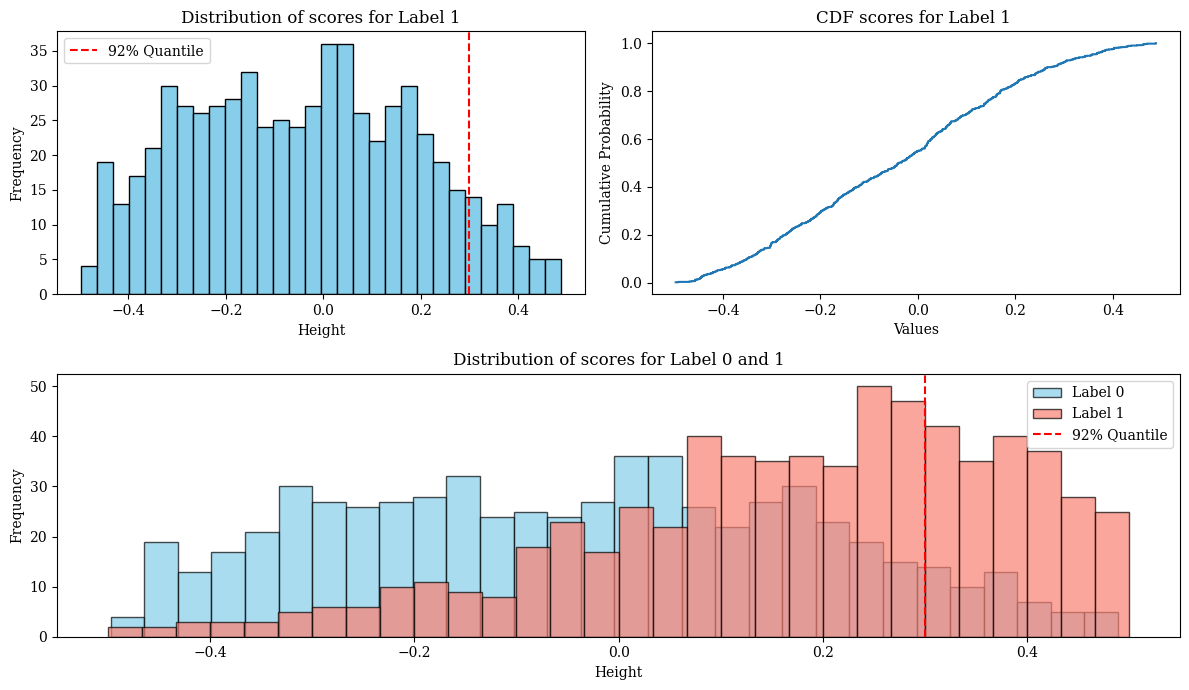

In [214]:
plt.figure(figsize=(12, 7))
ax1 = plt.subplot(2,2,1)  
ax2 = plt.subplot(2,2,2)
ax3 = plt.subplot(2,1,2)
fontsize = 14

ax1.hist(rho_bar, bins=30, color='skyblue', edgecolor='black')
ax1.axvline(x=qhat, color='r', linestyle='--', label=f'{1-epsilon:.0%} Quantile')
ax1.set_title('Distribution of scores for Label 1')
ax1.set_xlabel('Height')
ax1.set_ylabel('Frequency')
ax1.legend()

# Calculate the cumulative distribution function (CDF)
sorted_rho_bar = np.sort(rho_bar)
cumulative_counts = np.cumsum(np.ones_like(sorted_rho_bar))

# Normalize to get the cumulative probability
cumulative_prob = cumulative_counts / len(rho_bar)

# Plot the CDF
ax2.step(sorted_rho_bar, cumulative_prob, where='post')
ax2.set_xlabel('Values')
ax2.set_ylabel('Cumulative Probability')
ax2.set_title('CDF scores for Label 1 ')

# Histogram for label 0
ax3.hist(rho_bar01[Y_cal == 1], bins=30, color='skyblue', edgecolor='black', label='Label 0', alpha=0.7)
# Histogram for label 1
ax3.hist(rho_bar01[Y_cal == 0], bins=30, color='salmon', edgecolor='black', label='Label 1', alpha=0.7)
ax3.axvline(x=qhat, color='r', linestyle='--', label=f'{1-epsilon:.0%} Quantile')
ax3.set_title('Distribution of scores for Label 0 and 1')
ax3.set_xlabel('Height')
ax3.set_ylabel('Frequency')
plt.legend()


plt.tight_layout()

## 7.3 Computing the $\textrm{r-max}$

In [215]:
rho_bar = rho_bar.squeeze()
idx = rho_bar.argsort()[::-1]
rho_bar_sorted = rho_bar[idx]

r = np.ceil(epsilon*n_c/2)

## 7.4 Computing $\rho^*$

rho_star =  0.2953924


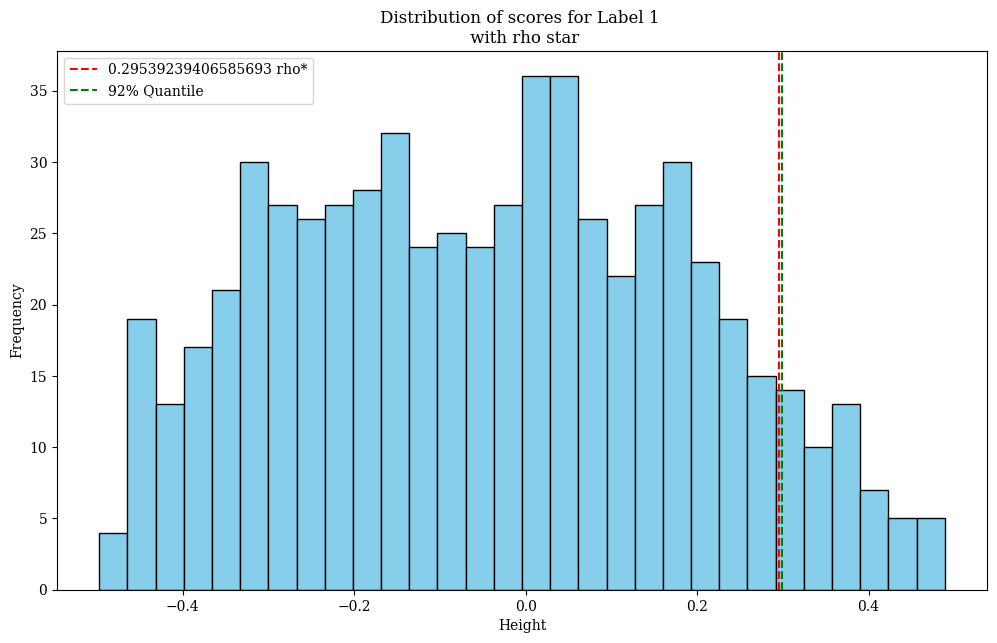

In [219]:
rho_star = rho_bar_sorted[int(r)]
print('rho_star = ',rho_star)

plt.figure(figsize=(12, 7))
fontsize = 14

plt.hist(rho_bar, bins=30, color='skyblue', edgecolor='black')
plt.axvline(x=rho_star, color='r', linestyle='--', label=f'{rho_star:} rho*')
plt.axvline(x=qhat, color='g', linestyle='--', label=f'{1-epsilon:.0%} Quantile')
plt.title('Distribution of scores for Label 1 \n with rho star')
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.legend()

## 7.5 Evaluate scaling

ACC = 0.6382978723404256, F1 = 0.7149613069647464, PPV = 0.5862859157412303, NPV = 0.8161543098251959, TPR = 0.9160011016248967, TNR = 0.3658470683599027

FPR = 0.6341529316400972, FNR = 0.08399889837510328
TP = 3326, FP = 2347, TN = 1354, FN = 305


<Figure size 1200x800 with 0 Axes>

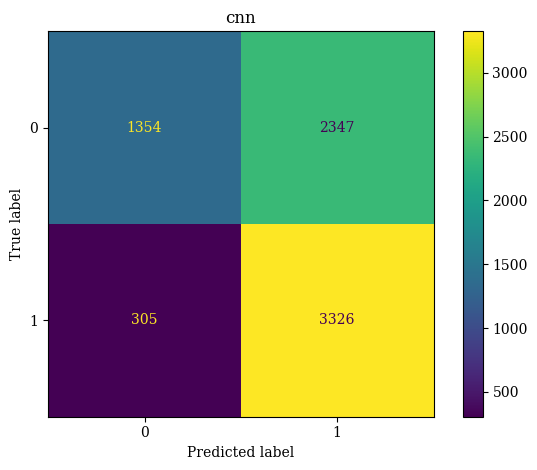

In [227]:
y_pred_ts_eps = []

#decision function

p_ts_star = p_ts + rho_star

for p in p_ts_star:
    if p<0:
        y_pred_ts_eps.append(0)
    else:
        y_pred_ts_eps.append(1)

plt.figure(figsize=(12, 8))

cm_svm = confusion_matrix(Y_test, y_pred_ts_eps)
cmSVM = ConfusionMatrixDisplay(confusion_matrix=cm_svm)
cmSVM.plot()
cmSVM.ax_.set_title("{}".format("cnn"))
plt.tight_layout()

TN, FP, FN, TP = confusion_matrix(Y_test, y_pred_ts_eps).ravel()


accuracy = (TP+TN)/(TP+TN+FP+FN)
f1 = (2*TP)/(2*TP+FP+FN)
PPV = TP/(TP+FP)
NPV = TN/(TN+FN)
TPR = TP/(TP+FN)
TNR = TN/(TN+FP)
FPR = FP/(FP+TN)
FNR = FN/(FN+TP)
print("ACC = {}, F1 = {}, PPV = {}, NPV = {}, TPR = {}, TNR = {}\n".format(accuracy,f1,PPV,NPV,TPR,TNR))

print(f"FPR = {FPR}, FNR = {FNR}")

print("TP = {}, FP = {}, TN = {}, FN = {}".format(TP,FP,TN,FN))



## 7.6 Tons of $\varepsilon$

In [ ]:
Epsilon = np.linspace(epsilon, 0.5, 100)

FPR_plt = []
FNR_plt = []

for eps in Epsilon:
        
    r1 = np.ceil(eps*n_c/2)
    rho_star1 = rho_bar_sorted[int(r1)]
    
    p_ts_star = p_ts + rho_star1
    
    y_pred_ts_eps = []

    for p in p_ts_star:
        if p<0:
            y_pred_ts_eps.append(0)
        else:
            y_pred_ts_eps.append(1)

    TN, FP, FN, TP = confusion_matrix(Y_test, y_pred_ts_eps).ravel()

    FPR = FP/(FP+TN)
    FNR = FN/(FN+TP)
    
    FPR_plt.append(FPR)
    FNR_plt.append(FNR)
   
    print(f"FPR = {FPR}, FNR = {FNR}")

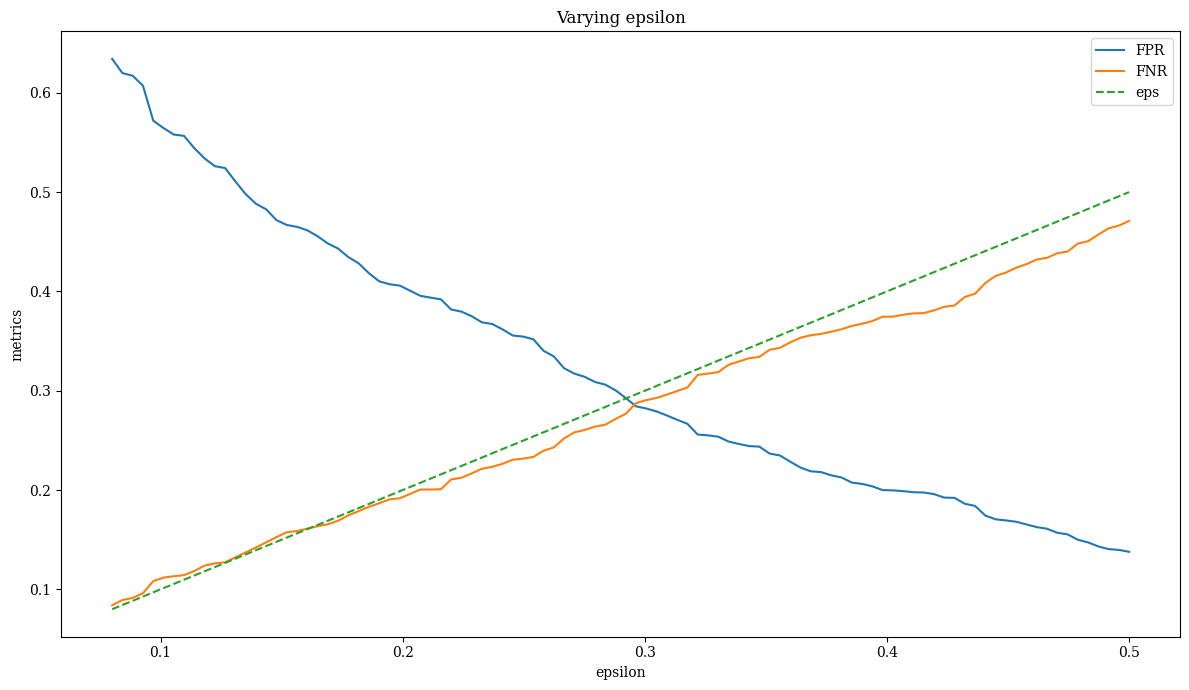

In [240]:
plt.figure(figsize=(12, 7))
fontsize = 14

plt.plot(Epsilon, FPR_plt, label = 'FPR')
plt.plot(Epsilon, FNR_plt, label = 'FNR')
plt.plot(Epsilon, Epsilon, label = 'eps', linestyle='--')
plt.title('Varying epsilon')
plt.xlabel('epsilon')
plt.ylabel('metrics')
plt.legend()
plt.tight_layout()